In [1]:
# Regression Problem - Boston Housing Price

import tensorflow as tf
from tensorflow.keras.datasets import boston_housing
from tensorflow.keras import models, layers, optimizers, utils
import numpy as np
import matplotlib.pyplot as plt


(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [2]:
print(train_data.shape)
print(test_data.shape)

(404, 13)
(102, 13)


In [3]:
# Normalization
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

In [4]:
# For Reusability, model is defined as a function.

def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation = 'relu', input_shape = (train_data.shape[1],))) # number of features (13) are used as vector in input shape
  model.add(layers.Dense(64, activation = 'relu'))
  model.add(layers.Dense(1)) # no activation function
  model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
  return model

In [5]:
k = 4
num_val_samples = len(train_data) // 4
num_epochs = 10
all_scores = []

for i in range(k):
  print('processing fold # ', i)
  # prepare the validation data: data from partition # k
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
  
  # prepare the training data: data from data - k
  partial_train_data = np.concatenate(                    
      [train_data[:i * num_val_samples],
      train_data[(i + 1 ) * num_val_samples:]],
  axis = 0)
  partial_train_targets = np.concatenate(
      [train_targets[:i * num_val_samples],
      train_targets[(i + 1 ) * num_val_samples:]],
  axis = 0)
  # Build the Keras Models (already commpiled)
  model = build_model()
  # Train the model (in silence mode, verbose = 0)
  model.fit(partial_train_data, partial_train_targets, epochs = num_epochs, batch_size = 1, verbose = 1)
  # Evaluate the model on the validation data
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose = 0)
  all_scores.append(val_mae)

processing fold #  0
Train on 303 samples
Epoch 1/10
303/303 [==============================] - 3s 9ms/sample - loss: 197.3600 - mae: 10.3955
Epoch 2/10
303/303 [==============================] - 1s 3ms/sample - loss: 26.9474 - mae: 3.3991
Epoch 3/10
303/303 [==============================] - 1s 3ms/sample - loss: 22.3588 - mae: 3.0016
Epoch 4/10
303/303 [==============================] - 1s 4ms/sample - loss: 19.0035 - mae: 2.8364
Epoch 5/10
303/303 [==============================] - 1s 4ms/sample - loss: 18.3643 - mae: 2.6396
Epoch 6/10
303/303 [==============================] - 1s 4ms/sample - loss: 16.8991 - mae: 2.6187
Epoch 7/10
303/303 [==============================] - 1s 4ms/sample - loss: 15.6518 - mae: 2.5569
Epoch 8/10
303/303 [==============================] - 1s 4ms/sample - loss: 14.5828 - mae: 2.4607
Epoch 9/10
303/303 [==============================] - 1s 4ms/sample - loss: 14.1989 - mae: 2.3798
Epoch 10/10
303/303 [==============================] - 1s 4ms/sample - los

In [6]:
all_scores

[2.0593965, 2.721386, 2.29863, 2.9649363]

In [7]:
np.mean(all_scores)

2.5110872

In [12]:
# Saving the validation logs at each fold
num_epochs = 10
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                         train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                            train_targets[(i + 1) * num_val_samples:]], axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [13]:
# Building the history of successive mean K-fold validation scores
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

# Plotting Validation Scores

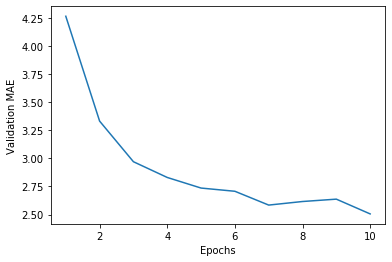

In [14]:
plt.plot(range(1, len(average_mae_history) + 1 ), average_mae_history)

plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

plt.show()

# Plotting Validation Scores - Excluding the first 10 data points

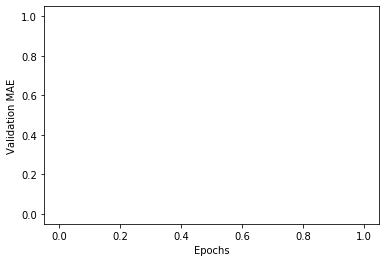

In [15]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1- factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

# Training the final model

In [16]:
model = build_model()

#Training on Entire Data
model.fit(train_data, train_targets, epochs = 80, batch_size = 16, verbose = 1)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

Train on 404 samples
Epoch 1/80
404/404 [==============================] - 1s 2ms/sample - loss: 484.9562 - mae: 20.1755
Epoch 2/80
404/404 [==============================] - 0s 322us/sample - loss: 316.5196 - mae: 15.6081
Epoch 3/80
404/404 [==============================] - 0s 351us/sample - loss: 168.6174 - mae: 10.4378
Epoch 4/80
404/404 [==============================] - 0s 323us/sample - loss: 86.3821 - mae: 7.0740
Epoch 5/80
404/404 [==============================] - 0s 318us/sample - loss: 53.2751 - mae: 5.4320
Epoch 6/80
404/404 [==============================] - 0s 312us/sample - loss: 35.5664 - mae: 4.2989
Epoch 7/80
404/404 [==============================] - 0s 322us/sample - loss: 26.6585 - mae: 3.6609
Epoch 8/80
404/404 [==============================] - 0s 338us/sample - loss: 22.2600 - mae: 3.2573
Epoch 9/80
404/404 [==============================] - 0s 351us/sample - loss: 19.6447 - mae: 3.1197
Epoch 10/80
404/404 [==============================] - 0s 322us/sample - lo

In [17]:
test_mse_score

17.44546553667854